<a href="https://colab.research.google.com/github/escape13/deepfried/blob/master/CNN/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the dataset

In [2]:
import torch
import numpy as np
from torchvision import datasets, transforms

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [5]:
train_data = datasets.CIFAR10('train/', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('test/', train=False, download=True, transform=transform)

Files already downloaded and verified


Extracting test/cifar-10-python.tar.gz to test/


In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=True)

In [7]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

## Visualizing the dataset

In [8]:
import matplotlib.pyplot as plt

In [9]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

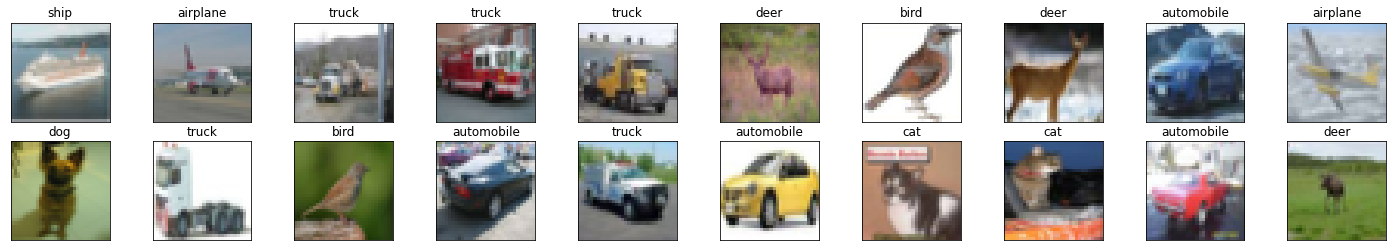

In [13]:
images, labels = iter(train_loader).next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])